<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Generate-Lognormal-distribution" data-toc-modified-id="Generate-Lognormal-distribution-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Generate Lognormal distribution</a></span></li><li><span><a href="#Lognormal-is-not-normal!" data-toc-modified-id="Lognormal-is-not-normal!-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Lognormal is not normal!</a></span></li><li><span><a href="#Single-day-expected-return" data-toc-modified-id="Single-day-expected-return-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Single day expected return</a></span><ul class="toc-item"><li><span><a href="#Based-on-lognormal-assumption" data-toc-modified-id="Based-on-lognormal-assumption-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Based on lognormal assumption</a></span></li><li><span><a href="#Based-on-normality-assumption" data-toc-modified-id="Based-on-normality-assumption-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Based on normality assumption</a></span></li></ul></li><li><span><a href="#Compounded-return" data-toc-modified-id="Compounded-return-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Compounded return</a></span><ul class="toc-item"><li><span><a href="#Based-on-lognormal-assumption" data-toc-modified-id="Based-on-lognormal-assumption-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Based on lognormal assumption</a></span></li><li><span><a href="#If-normality-assumed" data-toc-modified-id="If-normality-assumed-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>If normality assumed</a></span></li></ul></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Conclusions</a></span></li></ul></div>

# Generate Lognormal distribution

Suppose we have lognormal returns:

In [ ]:
from scipy.stats import shapiro, lognorm
from pingouin import qqplot
from seaborn import histplot
logn = lognorm(1,.0001,.001)
ret = logn.rvs(1000000)

# Lognormal is not normal!

Lognormal doesn't pass Shapiro test (keep number of samples reasonably small due to https://stats.stackexchange.com/questions/2492/is-normality-testing-essentially-useless):

In [30]:
T = 252
np.random.seed(42)
return_sample = np.random.choice(ret,T)
shapiro(return_sample)

ShapiroResult(statistic=0.6952812671661377, pvalue=4.193903852562234e-21)

Neither is Q-Q Plot any near to normality:

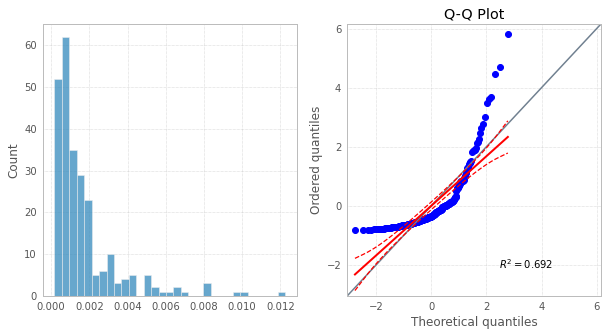

In [31]:
figure,axes = plt.subplots(1,2)
figure.set_size_inches((10,5))
histplot(return_sample, ax=axes[0])
qqplot(return_sample, ax=axes[1]);

# Single day expected return 

## Based on lognormal assumption

Single day estimates via properties of lognormal distribution properties:

- means of random samples drawn from lognormal distribution should lie within 2σ of estimated mean of lognormal

In [33]:
m, v = logn.stats(moments="mv")
s = np.sqrt(v)
N = 1000
i=0
for _ in range(N):
    m_ = np.random.choice(ret,252).mean()
    if np.abs(m_-m)>2*s: # within 2σ of lognormal
        i+=1
print(i/N)
print(m,s)

0.0
0.0017487212707001283 0.0021611974158950876


## Based on normality assumption

Single day estimates are insensitive to distribution assumptions:

In [34]:
m = ret.mean()
s = ret.std()
N = 1000
i=0
for _ in range(N):
    m_ = np.random.choice(ret,252).mean()
    if np.abs(m_-m)>2*s: # within 2σ of normal
        i+=1
print(i/N)
print(m,s)

0.0
0.001750051880319707 0.0021519994287162256


# Compounded return

## Based on lognormal assumption

Though if we try for compounding returns only μ and σ for lognormal ensure the right brackets:

In [52]:
log_ret = np.log(1+ret)
m_log = log_ret.mean()*T
s_log = log_ret.std()*np.sqrt(T)
m,v= lognorm.stats(1,m_log,s_log, moments="mv")
s = np.sqrt(v)
N = 1000
i=0
for _ in range(N):
    m_ = np.prod(1+np.random.choice(ret,T)) - 1
    if np.abs(m_-m)>2*s:
        i+=1
print(i/N)
print(m,s)

0.054
0.4959416758483652 0.07326363013031845


## If normality assumed

Note, if we try to estimate μ of compounding returns based on normality assumption, there will be unacceptable number of means out of confidense interval µ±2σ:

In [55]:
m = (1+ret.mean())**T -1
s = ret.std()*np.sqrt(T)
N = 1000
i=0
for _ in range(N):
    m_ = np.prod(1+np.random.choice(ret,T)) - 1
    if np.abs(m_-m)>2*s:
        i+=1
print(i/N)
print(m,s)

0.186
0.5536820431890146 0.034161931859617224


# Conclusions

- Single day estimates are insensitive to probability assumptions

- Compounded returns estimates should be based on log returns (normal)

- There are two ways to estimate μ and σ of lognormal distribution: 

    - through 3 parameter `scipy.stats.lognorm.stats(s, loc, scale, moments = 'mv')`, or
    - `lognstat(mu, sigma)`
    
```
def lognstat(mu, sigma):
    """Calculate the mean of and variance of the lognormal distribution given
    the mean (`mu`) and standard deviation (`sigma`), of the associated normal 
    distribution."""
    m = np.exp(mu + sigma**2 / 2.0)
    v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
    return m, v
```

- Note, estimating properties of log returns does not rely on normality assumption, because ***adding*** several random non-normal distributions results in a normal distribution, propeerties of which are well known